<ipython-input-8-afec99878ef1>:82: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_main, my_voice = wav.read(file_path)


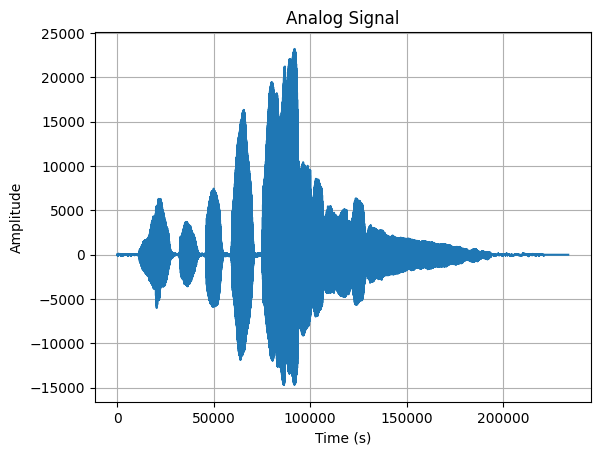

<ipython-input-8-afec99878ef1>:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_file, analog_signal = wav.read(file_path)


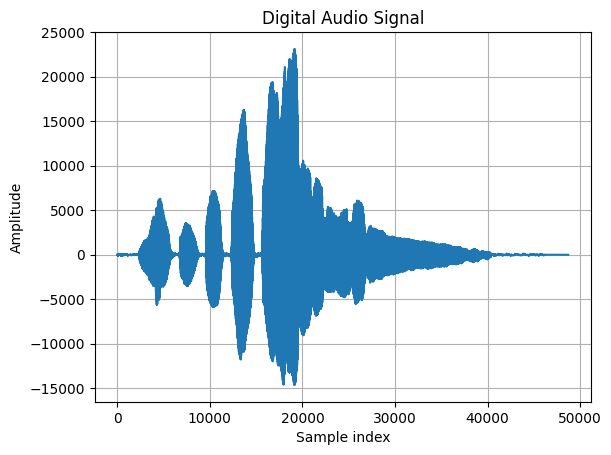

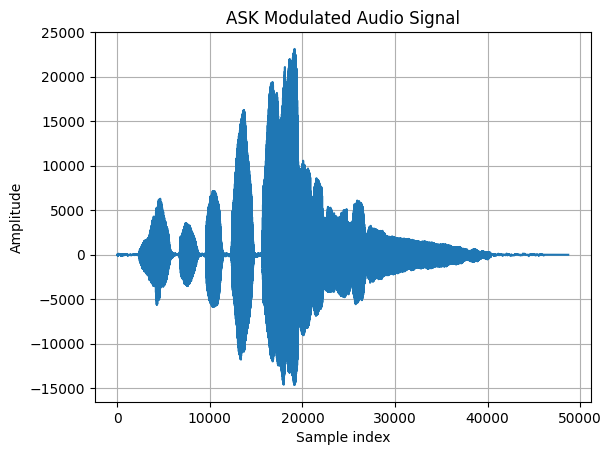

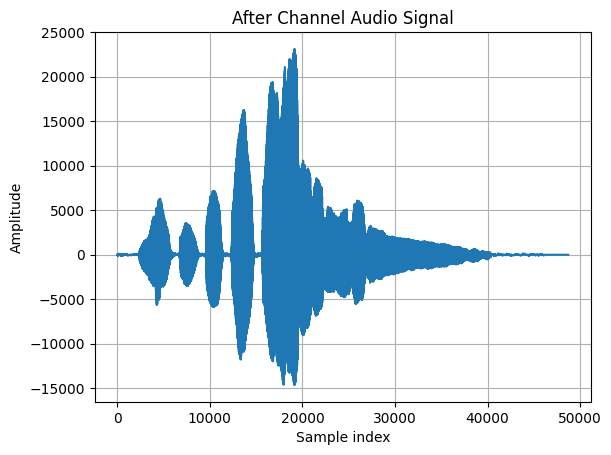

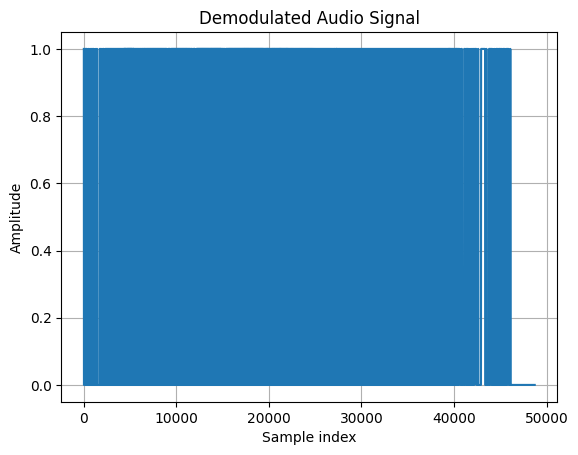

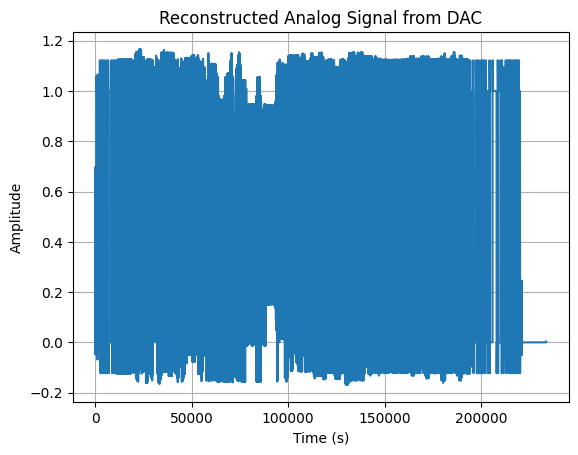

In [8]:
import numpy as np
from IPython.display import Audio
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt

def play_audio(audio_array, sample_rate, filename="output.wav"):
    # Normalize audio
    audio_array = np.int16(audio_array / np.max(np.abs(audio_array)) * 32767)

    # Save as WAV file
    wav.write(filename, sample_rate, audio_array)

    # Play the audio in Colab
    return Audio(filename, autoplay=True)

def adc(file_path, fs_in, delta):
    fs_file, analog_signal = wav.read(file_path)
    if len(analog_signal.shape) > 1:
        analog_signal = analog_signal[:, 0]  # Take one channel

    digital_signal = signal.resample(analog_signal, fs_in * len(analog_signal) // fs_file)
    fs_out = fs_file

    v_ref = np.max(np.abs(digital_signal))
    if v_ref == 0:
        return digital_signal, fs_out

    l = 2 * v_ref / delta
    normalized_signal = digital_signal / delta
    quantized_levels = np.round(normalized_signal)
    lower_bound, upper_bound = -l / 2, (l / 2) - 1
    quantized_levels = np.clip(quantized_levels, lower_bound, upper_bound)

    return quantized_levels * delta, fs_out

def ask_modulator(signal, fc, fs):
    t = np.arange(len(signal)) / fs
    return signal * np.cos(2 * np.pi * fc * t), t

def channel_awgn(tx_signal, bw, n0):
    sigma2 = n0 * bw
    noise = np.sqrt(sigma2) * np.random.randn(len(tx_signal))
    return tx_signal + noise, noise

def ask_demodulator(rx_signal, fc, fs):
    t = np.arange(len(rx_signal)) / fs
    mixed_signal = rx_signal * np.cos(2 * np.pi * fc * t)

    # Set cutoff frequency as a fraction of Nyquist frequency
    fc_cutoff = fc / 4  # Adjusted cutoff frequency
    if fc_cutoff >= fs / 2:  # Ensure it's in valid range
        fc_cutoff = fs / 4

    normalized_cutoff = fc_cutoff / (fs / 2)  # Normalize for firwin()

    # Ensure the filter order is reasonable
    filter_order = max(50, min(500, round(fs / fc * 10)))  # Dynamic filter order

    # Low-pass filter design
    lpf = signal.firwin(filter_order, normalized_cutoff)

    # Apply zero-phase filtering
    demod_signal = signal.filtfilt(lpf, 1, mixed_signal)

    return (demod_signal > np.mean(demod_signal)).astype(int)

def dac(input_signal, fs, fs_main):
    # Design a low-pass filter
    b, a = signal.butter(4, fs / fs_main, btype='low', analog=False)

    # Apply the filter
    filtered_signal = signal.lfilter(b, a, input_signal)

    # Resample to match the original sample rate
    resampled_signal = signal.resample(filtered_signal, fs_main * len(filtered_signal) // fs)

    return resampled_signal

# Load and process the audio file
file_path = 'audio.wav'
fs_main, my_voice = wav.read(file_path)
plt.figure()
plt.plot(my_voice)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Analog Signal')
plt.grid(True)
plt.show()

# Parameters
delta_adc = 0.001
fs = 10000
fc_ask = 20000
bw_ch = 5000
n0 = 0.000001

# ADC
quantized_signal, fs_used = adc(file_path, fs, delta_adc)
plt.figure()
plt.plot(quantized_signal)
plt.title('Digital Audio Signal')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# ASK Modulation
ask_signal, t = ask_modulator(quantized_signal, fc_ask, fs)
plt.figure()
plt.plot(ask_signal)
plt.title('ASK Modulated Audio Signal')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Channel
rx_signal, noise_samples = channel_awgn(ask_signal, bw_ch, n0)
plt.figure()
plt.plot(rx_signal)
plt.title('After Channel Audio Signal')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# ASK Demodulation
demodulated_signal = ask_demodulator(rx_signal, fc_ask, fs)
plt.figure()
plt.plot(demodulated_signal)
plt.title('Demodulated Audio Signal')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# DAC
analog_signal = dac(demodulated_signal, fs, fs_used)
plt.figure()
plt.plot(analog_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Reconstructed Analog Signal from DAC')
plt.grid(True)
plt.show()
play_audio(analog_signal, fs)